# Neural Computation (Autumn 2019)
# Lab 7: Neural Networks for Visual Recognition

In these weeks, you should have known how to use python and pytorch to build your own network. This week, we will introduce how to use network to do some simple classfication tasks. By the end of this tutorial, you will know:

- How to create simple test data to test your network
- How to train a Softmax Linear Classifier
- How to train a Neural Network

## Pytorch Tensors


# Generating Data
We will genearte some data to for the following test.


In [3]:
import numpy as np
import matplotlib.pyplot as plt

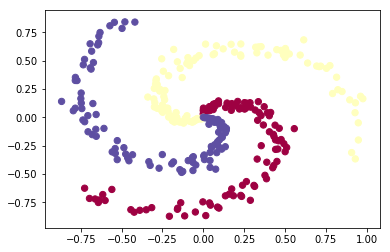

In [52]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

The toy spiral data consists of three classes (blue, red, yellow) that are not linearly separable.

# Training a Softmax Linear Classifier

First we train a Softmax classifier on this toy dataset. The Softmax classifier is defined as:

score = W*x+b

where W is weight matrix and b is bias vector for each class. We first initialize these parameters to be random numbers.

In [53]:
# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

# D is the dimensionality of data and K is the number of classes.

Compute the class scores:

In [54]:
def get_scores(x,w,b):

    scores = np.dot(X, W) + b
    return scores

# Compute the loss:
Then we need define a loss function, which is a differentiable objective that quantifies the cost with the computed class scores. Intuitively, we want the correct class to have a higher score than the other classes. When this is the case, the loss should be low and otherwise the loss should be high. There are many ways to quantify this intuition, but in this example we use the cross-entropy loss that is associated with the Softmax classifier:


$$
L_{i}=-\log \left(\frac{e^{f_{y_{i}}}}{\sum_{j} e^{f_{j}}}\right),
$$

where $f$ is the array of class scores for a single example. We can see that the Softmax classifier interprets every element of f as holding the (unnormalized) log probabilities of the three classes. We exponentiate these to get (unnormalized) probabilities, and then normalize them to get probabilites. Therefore, the expression inside the log is the normalized probability of the correct class. Note how this expression works: this quantity is always between 0 and 1. When the probability of the correct class is very small (near 0), the loss will go towards (positive) infinity. Conversely, when the correct class probability goes towards 1, the loss will go towards zero because log(1)=0. Hence, the expression for Li is low when the correct class probability is high, and it’s very high when it is low.

The full Softmax classifier loss is then defined as the average cross-entropy loss over the training examples and the regularization:
$$
L=\underbrace{\frac{1}{N} \sum_{i} L_{i}}_{\text {data loss }}+\underbrace{\frac{1}{2} \lambda \sum_{k} \sum_{l} W_{k, l}^{2}}_{\text {regularization loss }}
$$

Given the scores and the definition of loss function, we can compute the loss:


In [55]:
num_examples = X.shape[0]
# get unnormalized probabilities

scores = get_scores(X,W,b)
exp_scores = np.exp(scores)
# normalize them for each example
probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
correct_logprobs = -np.log(probs[range(num_examples),y])

data_loss = np.sum(correct_logprobs)/num_examples
lam = 0.5
reg_loss = 0.5*lam*np.sum(W*W)
loss = data_loss + reg_loss

# Computing the Analytic Gradient with Backpropagation
We have a way of evaluating the loss, and now we have to minimize it. We’ll do so with gradient descent. That is, we start with random parameters (as shown above), and evaluate the gradient of the loss function with respect to the parameters, so that we know how we should change the parameters to decrease the loss. Lets introduce the intermediate variable p, which is a vector of the (normalized) probabilities. The loss for one example is:
$$
p_{k}=\frac{e^{f_{k}}}{\sum_{j} e^{f_{j}}} \quad L_{i}=-\log \left(p_{y_{i}}\right)
$$

We now wish to understand how the computed scores inside f should change to decrease the loss $L_i$ that this example contributes to the full objective. In other words, we want to derive the gradient $\partial L_{i} / \partial f_{k}$. The loss $L_i$ is computed from p, which in turn depends on f. It’s a fun exercise to the reader to use the chain rule to derive the gradient, but it turns out to be extremely simple and interpretible in the end, after a lot of things cancel out:
$$
\frac{\partial L_{i}}{\partial f_{k}}=p_{k}-1\left(y_{i}=k\right)
$$
Notice how elegant and simple this expression is. Suppose the probabilities we computed were p = [0.2, 0.3, 0.5], and that the correct class was the middle one (with probability 0.3). According to this derivation the gradient on the scores would be df = [0.2, -0.7, 0.5]. We see that this result is highly intuitive: increasing the first or last element of the score vector f (the scores of the incorrect classes) leads to an increased loss (due to the positive signs +0.2 and +0.5) - and increasing the loss is bad, as expected. However, increasing the score of the correct class has negative influence on the loss. The gradient of -0.7 is telling us that increasing the correct class score would lead to a decrease of the loss $L_i$, which makes sense.

In [ ]:
Now we can get loss by:

In [81]:
def get_loss(scores, data_size, reg):
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
      # compute the loss: average cross-entropy loss and regularization
    correct_logprobs = -np.log(probs[range(data_size),y])
    data_loss = np.sum(correct_logprobs)/data_size
    reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
    loss = data_loss + reg_loss
    return loss

All of this boils down to the following code. probs stores the probabilities of all classes (as rows) for each example. To get the gradient on the scores, which we call dscores, we proceed as follows:

In [82]:
dscores = probs
dscores[range(num_examples),y] -= 1
dscores /= num_examples

In [83]:
dW = np.dot(X.T, dscores)
db = np.sum(dscores, axis=0, keepdims=True)
dW += lam*W # don't forget the regularization gradient

Where we see that we have backpropped through the matrix multiply operation, and also added the contribution from the regularization. Note that the regularization gradient has the very simple form reg*W since we used the constant 0.5 for its loss contribution. This is a common convenience trick that simplifies the gradient expression.

## Performing a parameter update
Now that we’ve evaluated the gradient we know how every parameter influences the loss function. We will now perform a parameter update in the negative gradient direction to decrease the loss:

In [84]:
# perform a parameter update
W += -step_size * dW
b += -step_size * db

In [85]:
## Putting it all together: Training a Softmax Classifier

In [86]:
#Train a Linear Classifier

# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
lam = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(200):
  
  # evaluate class scores, [N x K]
  scores = get_scores(X,W,b)
  
  # compute the loss

  loss = get_loss(scores, num_examples, reg)
    
    
  if i % 10 == 0:
    print ("iteration %d: loss %f" % (i, loss))
  
  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples
  
  # backpropate the gradient to the parameters (W,b)
  dW = np.dot(X.T, dscores)
  db = np.sum(dscores, axis=0, keepdims=True)
  
  dW += lam*W # regularization gradient
  
  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db

iteration 0: loss 1.167806
iteration 10: loss 0.937234
iteration 20: loss 0.842863
iteration 30: loss 0.829770
iteration 40: loss 0.861118
iteration 50: loss 0.917762
iteration 60: loss 0.990229
iteration 70: loss 1.073562
iteration 80: loss 1.164912
iteration 90: loss 1.262491
iteration 100: loss 1.365090
iteration 110: loss 1.471843
iteration 120: loss 1.582107
iteration 130: loss 1.695388
iteration 140: loss 1.811294
iteration 150: loss 1.929511
iteration 160: loss 2.049781
iteration 170: loss 2.171889
iteration 180: loss 2.295652
iteration 190: loss 2.420913


We see that we’ve converged to something after about 190 iterations. We can evaluate the training set accuracy:

training accuracy: 0.50


(-1.8746454750978199, 1.8253545249021834)

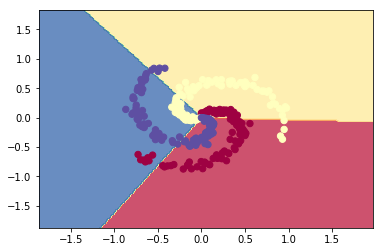

In [87]:
scores = np.dot(X, W) + b
predicted_class = np.argmax(scores, axis=1)
print ('training accuracy: %.2f' % (np.mean(predicted_class == y)))

# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

##Linear classifier fails to learn the toy spiral dataset



# Training a Neural Network
Clearly, a linear classifier is inadequate for this dataset and we would like to use a Neural Network. One additional hidden layer will suffice for this toy data. We will now need two sets of weights and biases (for the first and second layers):

In [62]:
# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

In [63]:
# evaluate class scores with a 2-layer Neural Network
hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
scores = np.dot(hidden_layer, W2) + b2

Notice that the only change from before is one extra line of code, where we first compute the hidden layer representation and then the scores based on this hidden layer. Crucially, we’ve also added a non-linearity, which in this case is simple ReLU that thresholds the activations on the hidden layer at zero.

Everything else remains the same. We compute the loss based on the scores exactly as before, and get the gradient for the scores dscores exactly as before. However, the way we backpropagate that gradient into the model parameters now changes form, of course. First lets backpropagate the second layer of the Neural Network. This looks identical to the code we had for the Softmax classifier, except we’re replacing X (the raw data), with the variable hidden_layer):

In [64]:
# backpropate the gradient to the parameters
# first backprop into parameters W2 and b2
dW2 = np.dot(hidden_layer.T, dscores)
db2 = np.sum(dscores, axis=0, keepdims=True)

However, unlike before we are not yet done, because hidden_layer is itself a function of other parameters and the data! We need to continue backpropagation through this variable. Its gradient can be computed as:

In [65]:
dhidden = np.dot(dscores, W2.T)

Now we have the gradient on the outputs of the hidden layer. Next, we have to backpropagate the ReLU non-linearity. This turns out to be easy because ReLU during the backward pass is effectively a switch. Since r=max(0,x), we have that $\frac{d r}{d x}=1(x>0)$. Combined with the chain rule, we see that the ReLU unit lets the gradient pass through unchanged if its input was greater than 0, but kills it if its input was less than zero during the forward pass. Hence, we can backpropagate the ReLU in place simply with:

In [66]:
# backprop the ReLU non-linearity
dhidden[hidden_layer <= 0] = 0

In [67]:
# finally into W,b
dW = np.dot(X.T, dhidden)
db = np.sum(dhidden, axis=0, keepdims=True)

We’re done! We have the gradients dW,db,dW2,db2 and can perform the parameter update. Everything else remains unchanged. The full code looks very similar:

In [89]:
# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0
reg = 1e-3 # regularization strength

# gradient descent loop
num_examples = X.shape[0]
for i in range(10000):
  
  # evaluate class scores, [N x K]
  hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
  scores = np.dot(hidden_layer, W2) + b2
  
  # compute the class probabilities
  exp_scores = np.exp(scores)
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
  # compute the loss

  loss  = get_loss(scores,num_examples,reg)
  if i % 1000 == 0:
    print ("iteration %d: loss %f" % (i, loss))
  
  # compute the gradient on scores
  dscores = probs
  dscores[range(num_examples),y] -= 1
  dscores /= num_examples
  
  # backpropate the gradient to the parameters
  # first backprop into parameters W2 and b2
  dW2 = np.dot(hidden_layer.T, dscores)
  db2 = np.sum(dscores, axis=0, keepdims=True)
  # next backprop into hidden layer
  dhidden = np.dot(dscores, W2.T)
  # backprop the ReLU non-linearity
  dhidden[hidden_layer <= 0] = 0
  # finally into W,b
  dW = np.dot(X.T, dhidden)
  db = np.sum(dhidden, axis=0, keepdims=True)
  
  # add regularization gradient contribution
  dW2 += reg * W2
  dW += reg * W
  
  # perform a parameter update
  W += -step_size * dW
  b += -step_size * db
  W2 += -step_size * dW2
  b2 += -step_size * db2

iteration 0: loss 1.098772
iteration 1000: loss 0.282704
iteration 2000: loss 0.249870
iteration 3000: loss 0.245723
iteration 4000: loss 0.242911
iteration 5000: loss 0.241560
iteration 6000: loss 0.241106
iteration 7000: loss 0.240977
iteration 8000: loss 0.240919
iteration 9000: loss 0.240875


training accuracy: 0.99


(-1.8746454750978199, 1.8253545249021834)

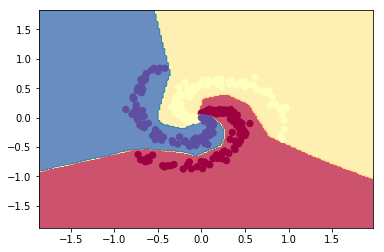

In [69]:
# evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(X, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print ('training accuracy: %.2f' % (np.mean(predicted_class == y)))
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W2) + b2
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# Train a network in Pytorch

For more details about the previous examples, you can visit this website: http://cs231n.github.io/neural-networks-case-study/.
Now we will show you how to train a network in Pytorch.

In [134]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Now we define a 3 layers network like this


In [163]:
class class_data(nn.Module):
    def __init__(self):
        super(class_data, self).__init__()

        self.conv1 = torch.nn.Conv1d(2, 100, 1) 
        self.conv2 = torch.nn.Conv1d(100, 100, 1)
        self.conv3 = torch.nn.Conv1d(100, 3, 1)


    def forward(self, x):
  
        x = self.conv1(x)
        x = F.relu(self.conv2(x))
        x = (self.conv3(x))
      
   
        return x






In [218]:
X1 = torch.Tensor(X)
data_size = X1.shape[0]
X1 = X1.unsqueeze(0)
print(X1.shape)
reg = 0.5
labels = y
loss_fn = nn.CrossEntropyLoss()
labels = torch.Tensor(labels)
labels = labels.unsqueeze(0)
classifier = class_data() 
optimizer = optim.SGD(classifier.parameters(), lr =0.01, momentum=0.9)
batchsize = 300

for i in range(1000):
    choice = np.random.choice(data_size, batchsize, replace=False)
    X_ = X1[0:1,choice,:]
    labels_ =  labels[0:1,choice]
    
#     print(X2.shape)
    optimizer.zero_grad()
    output = classifier(X_.transpose(1,2))
#     print(output[0,:,1:10])
#     print(labels[0,1:10])
    loss = loss_fn(output, labels_.long())
    loss.backward()
    if i %1000==0:
        print(loss)
    optimizer.step()

print('Training done')
preds = output.max(1)[1]




torch.Size([1, 300, 2])
tensor(1.0867)
Training done


In [219]:
preds.numpy()[0,:].shape

(300,)

(-1.8746454750978199, 1.8253545249021834)

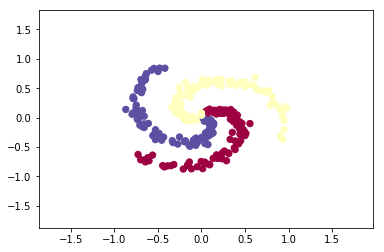

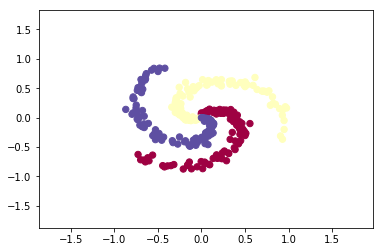

In [220]:
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


## prediction show
fig = plt.figure()
plt.scatter(X[choice, 0], X[choice, 1], c=preds.numpy()[0,:], s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())


## ground truth show
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())


